# 5. Create Machine Learning data

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline 


### 5.0 Create directory structure for storing data 

In [3]:
import os
def check_and_create_directories():
    """
    Checks and create a nested directory structure for machine learning data.
    
    The structure checked is:
    - Machine_Learning
        - models
        - data
            - test_data
            - test_masks
            - train_data
            - train_masks
    """
    root_dir = "Machine_Learning/data"
    # List of directories under the ILC directory
    sub_dirs = ["test_data", "test_masks", "train_data","train_masks"]

    # Create the root directory and its subdirectories
    create_directory(root_dir)

    # Store Model 
    create_directory("Machine_Learning/models")
    
    for sub_dir in sub_dirs:
        create_directory(os.path.join(root_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed

check_and_create_directories()


Directory already exists: Machine_Learning/data
Directory already exists: Machine_Learning/models
Directory already exists: Machine_Learning/data/test_data
Directory already exists: Machine_Learning/data/test_masks
Directory already exists: Machine_Learning/data/train_data
Directory already exists: Machine_Learning/data/train_masks


### 5.1 Input explanation

Standard U-Net takes in square images instead of rectangular images.

Temporal solution: Split the map into two maps and use one side as the input.

Unfinished task: Processing the entire map as one input in the Machine learning model.

(Resizing might distort the image)



(256, 256)
(256, 256)


(256, 511)

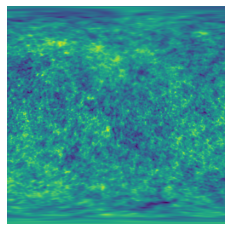

In [ ]:
ILC_data = np.real(np.load("ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R0000.npy"))
print(ILC_data.shape)
ILC_data_middle = (ILC_data.shape[1]+1)/2
ILC_data_Left = ILC_data[:,0:ILC_data_middle]
ILC_data_Right = np.concatenate([ILC_data[:,ILC_data_middle:],ILC_data_Left[:,0:1]], axis=1)
print(ILC_data_Left.shape)
print(ILC_data_Right.shape)
plt.imshow(np.real(ILC_data_Left))
plt.axis("off")


### 5.2 Data preparation functions

### Reference: https://arxiv.org/abs/2404.03557

#### Input: Signal free frequency maps
We don't want the model to include any true CMB signal in the residual prediction. Therefore, we remove the CMB signal from the frequency maps.

Signal free frequency maps = (simulated total map from skyclean step 2) - (ILC estimation of CMB signal)

Note:
ILC estimation of CMB signal contains the entire CMB signal + some residuals

Planck data has 9 frequencies, thus, there will be 9 signal free maps for each realization. 

9 maps are stored together at Machine_Learning/data/train_data/CMB_Free_MW_Map_F9_L{desired_lmax}_R{realziaiton}.npy as 1 input.

##### Target Prediction / mask : ILC residual prediction. 

ILC residual = (ILC estimation of CMB signal) - (simulated true CMB signal)

In [156]:
def hp_pix_2_mw_pix(hp_pix, lmax):
    mw_pix = np.real(s2fft.inverse(hp_alm_2_mw_alm(hp.map2alm(hp_pix, lmax-1),lmax),lmax))
    return mw_pix

def hp_map_2_hp_alm(healpix_map, L_max):
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

def read_healpix_map(CMB_map_path, title = "", plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)

    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title=title,
            unit=r"$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

def process_map(map_data, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Args:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    alm = hp.map2alm(map_data, lmax=lmax)
    processed_map = hp.alm2map(alm, nside=nside)
    return processed_map, alm

def save_map(map_data,templete, frequency, lmax, realization):
    """
    Saves the processed map to a file with a specific naming convention.
    
    Args:
        map_data (numpy.ndarray): Map data to be saved.
        map_type (str): Type of the map (e.g., "CMB", "Synchrotron", "Noise", "CSN").
        frequency (str): Frequency identifier.
        lmax (int): Maximum multipole moment used in processing.
        realization (str): Realization identifier.
    """
  
    file_name = templete.format(frequency = frequency, lmax = lmax, realization = realization)
    np.save(file_name, map_data)
    
    print(f"Map saved to {file_name}")

def map_subtract(map1_path, map2_path, operation = "Signal_Free", lmax = 256):

 
    """
    Subtracts one map from another based on the specified operation and returns the result.

    This function reads two input maps from the specified file paths, processes them according to the
    specified operation, and returns the result of subtracting the second map from the first.

    Args:
    -----
    map1_path (str): The file path to the first map. The map can be in HEALPix format or a numpy array (.npy).
    map2_path (str): The file path to the second map. The map can be in HEALPix format or a numpy array (.npy).
    operation (str, optional): Specifies the type of operation to perform on the maps before subtraction. 
    
                              
    lmax (int, optional): The maximum multipole order used for the MW conversion. Defaults to 256.

    Returns:
    --------
    np.ndarray: The result of subtracting the processed second map from the processed first map.
    
    """

     # Signal_Free: The first map is converted from HEALPix to MW format, and the second map is read as a numpy array.
    if operation == "Signal_Free":
        map1 = hp_pix_2_mw_pix(read_healpix_map(map1_path), lmax)
        map2 = np.real(np.load((map2_path)))
    
    
    # CMB_Residual: The first map is read as a numpy array, and the second map is converted from HEALPix to MW format.
    elif operation == "CMB_Residual":
        map1 = np.real(np.load((map1_path)))
        map2 = hp_pix_2_mw_pix(read_healpix_map(map2_path), lmax)

    return (map1 - map2)

def prepare_data(frequencies, realizations, desired_lmax, directory="CMB_total"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """

    for realization in realizations:
        realziaiton_str = str(realization).zfill(4)
        print(f"Processing realization {realziaiton_str}")
        ILC_path = f"ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realziaiton_str}.npy"
        
        all_frequneices = []
        for frequency in frequencies:
            print(f"Processing frequency {frequency}")
            
            CMB_free = f"Machine_Learning/data/train_data/CMB_Free_MW_Map_F9_L{desired_lmax}_R{realziaiton_str}.npy"
            if os.path.exists(CMB_free):
                print(f"File {CMB_free} already exists. Skipping download.")
                continue
            
            CSN_path =  f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realziaiton_str}.fits"
            signal_free_map = map_subtract(CSN_path,ILC_path, operation = "Signal_Free", lmax = desired_lmax)
            all_frequneices.append(signal_free_map[:,0:desired_lmax])
        CMB_free_templete = "Machine_Learning/data/train_data/CMB_Free_MW_Map_F{frequency}_L{lmax}_R{realization}.npy"
        save_map(all_frequneices, CMB_free_templete, "9", desired_lmax, f"{realziaiton_str}")
            
        CMB_residual_path = f"Machine_Learning/data/train_masks/CMB_residual_MW_Map_F100_L{desired_lmax}_R{realziaiton_str}.npy"
        if os.path.exists(CMB_residual_path):
            print(f"File {CMB_residual_path} already exists. Skipping download.")
            continue
        
        # Create Mask: True CMB residual 
        # User choice: Use 100 GHz CMB map as the true CMB map
        CMB_path =  f"CMB_total/CMB_HP_Map_F100_L{desired_lmax}_R{realziaiton_str}.fits"
        CMB_residual = map_subtract(ILC_path, CMB_path, "CMB_Residual", lmax = desired_lmax)
        CMB_free_templete = "Machine_Learning/data/train_masks/CMB_Residual_MW_Map_F{frequency}_L{lmax}_R{realization}.npy"
        save_map(CMB_residual[:,0:256], CMB_free_templete, "100", desired_lmax, f"{realziaiton_str}")

# Define frequencies and realizations
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# frequencies = ["030"]

realizations = list(range(10))  # Realizations from 0 to 9
desired_lmax = 256
# Example usage with user-defined lmax
prepare_data(frequencies, realizations, desired_lmax=desired_lmax)


Processing realization 0000
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency 857
Map saved to train_data/CMB_Free_MW_Map_F9_L256_R0000.npy
Map saved to train_masks/CMB_Residual_MW_Map_F100_L256_R0000.npy
Processing realization 0001
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency 857
Map saved to train_data/CMB_Free_MW_Map_F9_L256_R0001.npy
Map saved to train_masks/CMB_Residual_MW_Map_F100_L256_R0001.npy
Processing realization 0002
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency